# 3. NYC Taxi: Прогнозирование ряда со сложной сезонностью

Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, как учесть сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида:
$$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), i=1,\dots, K.$$
Здесь $T$ — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра $K$ вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять K равным 2-5).

Если вы собрали данные за несколько лет, аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов.

Если в данных есть линейный или описываемый ещё какой-то простой функцией $f$ тренд, стоит добавить к регрессионным признакам вектор $[1,…,T]$ или, соответственно, #f([1,…,T])#.

Если вы забыли, как в statsmodels работать с моделями ARIMA, почитайте туториал от создателей.

Чтобы сдать задание, выполните следующую последовательность действий.

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. **Не используйте данные за последний имеющийся месяц — июнь 2016!** Создайте регрессионные признаки для учёта сезонностей и трендов.
2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.
3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров $p,q,P,Q$. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов $K$ или поменять порядки дифференцирования.
6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from sklearn import metrics 
import itertools
import os
from glob import glob
import pickle
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%time
# загружаем данные (за 6 месяцев)
f_lst = glob('agr_tripdata_*.pkl')
data = pd.DataFrame()
for f in f_lst:
    data = data.append(pd.read_pickle(f))
print(data.shape)

(10980000, 3)
Wall time: 683 ms


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10980000 entries, 0 to 1859999
Data columns (total 3 columns):
date    datetime64[ns]
bins    int16
numb    int16
dtypes: datetime64[ns](1), int16(2)
memory usage: 209.4 MB


## 1. Выбор зоны, создание регрессионных признаков

In [5]:
# выбираем для анализа самую "нагруженную" ячейку
cell_idx = data.groupby('bins').sum().idxmax()
print('выбираем ячейку {0}, из которой за период совершено {1:,.0f} поездок'
      .format(cell_idx[0], data.groupby('bins').sum().max()[0]))

выбираем ячейку 1282, из которой за период совершено 3,905,843 поездок


In [6]:
# выбираем данные по выбранной ячейки
cell_data = pd.DataFrame(data.numb[data.bins == cell_idx[0]].values, 
                         index=data.date[data.bins == cell_idx[0]].values,
                         columns=['numb'])
cell_data.sort_index(inplace=True)
cell_data.head()

,numb
2015-12-01 00:00:00,502
2015-12-01 01:00:00,252
2015-12-01 02:00:00,135
2015-12-01 03:00:00,80
2015-12-01 04:00:00,56


In [7]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2015-12-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 1 columns):
numb    4392 non-null int16
dtypes: int16(1)
memory usage: 42.9 KB


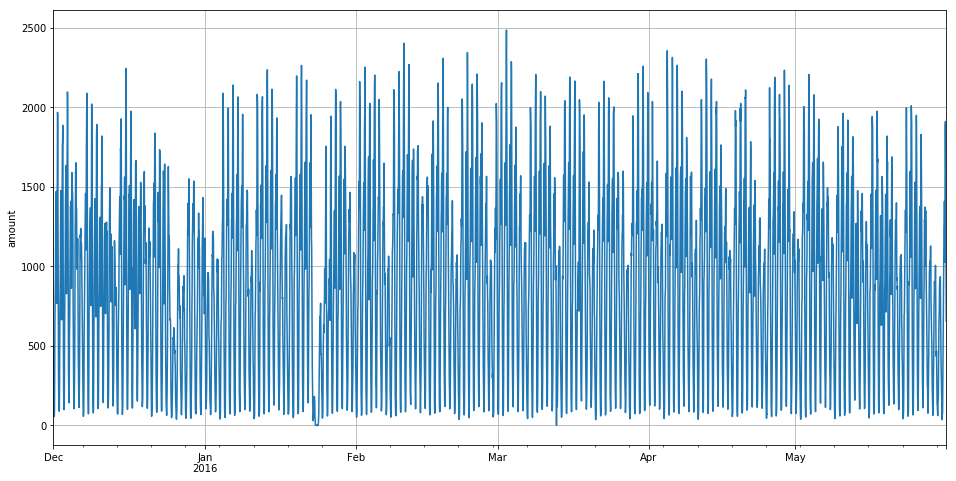

In [8]:
# рассмотрим ряд изначальный
cell_data.plot(figsize=(16,8), grid=True, legend=False)
plt.ylabel('amount')
pylab.show()

"""
Ярко выражена сезонность суточная и недельная. Дисперсия, будем считать, в стабилизации не нуждается
Ярко выраженного тренда тоже не наблюдаю. Есть пара провалов: Рождество и аномальный снегопад в Нью-Йорке 23.01.2016
И в конце мая - праздник День памяти (30.05.2016) после двух выходных
Были попытки сделать отдельные признаки по праздникам, но как-то я не нашел эту затею дельной... Может не прав
"""
pass

Критерий Дики-Фуллера: p=0.000000


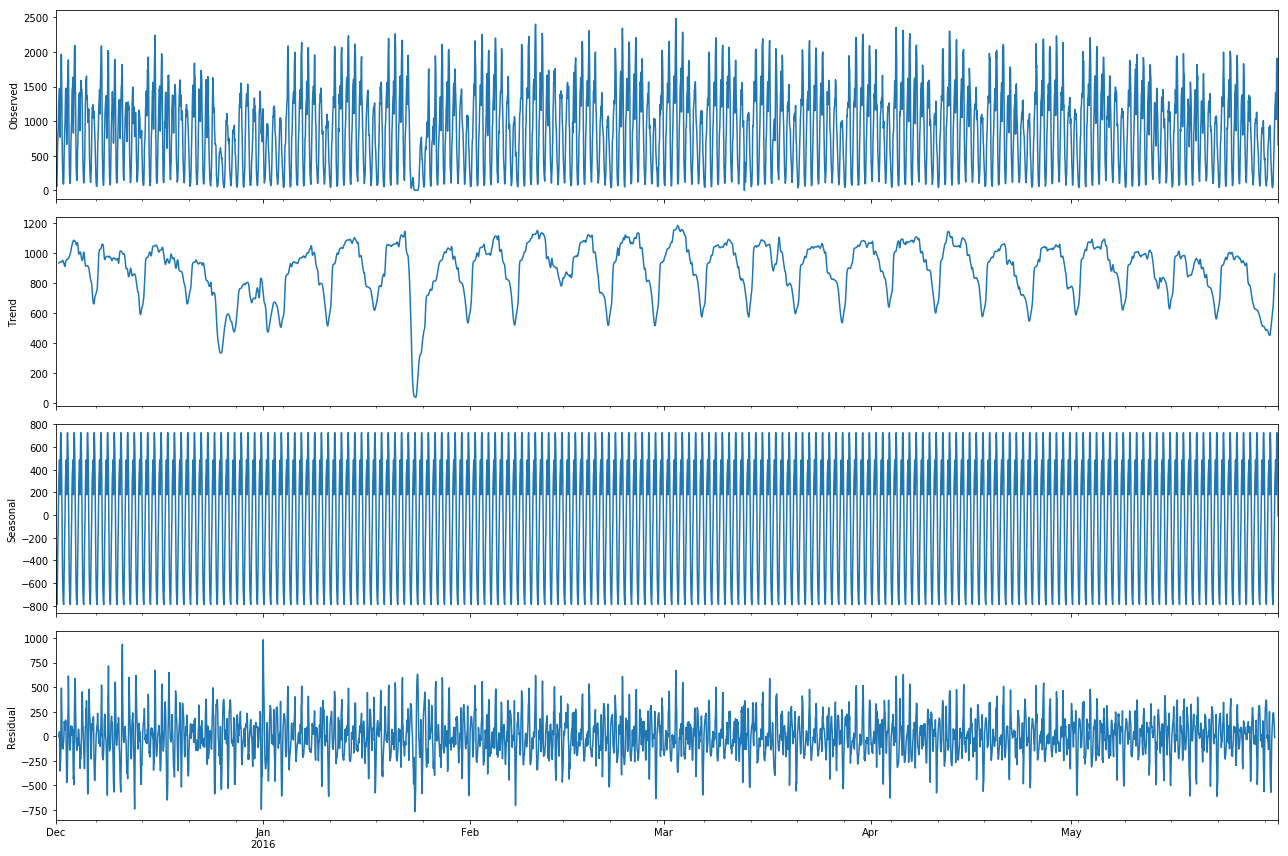

In [9]:
plt.figure(figsize(18,12))
sm.tsa.seasonal_decompose(cell_data).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(cell_data.numb/60)[1])

"""
Критерий Дики-Фуллера сразу отвергает гипотезу нестационарности. Но все не просто, как и обещали.
Трендовая компонента имеет явную недельную сезонность. Будем пытаться от нее избавиться с помощью регрессии
"""
pass

In [10]:
# процедура формирования массива признаков 
def gen_features(cell_data, ii):
    # генерируем значения
    sin_i = [np.sin(np.array(range(1, len(cell_data)+1))*2*np.pi*i/168)
             for i in ii]
    cos_i = [np.cos(np.array(range(1, len(cell_data)+1))*2*np.pi*i/168)
             for i in ii]
    # наименования переменны x_[_s, _c] - синус/косинус [_i] - множитель
    name_s = ['x_s_'+str(i) for i in ii]
    name_c = ['x_c_'+str(i) for i in ii]
    # соберем в таблицу, добавим отклик и проиндексируем
    features = pd.DataFrame(sin_i + cos_i).T
    features.columns = name_s + name_c
    features['y'] = cell_data.numb.values
    features.index = cell_data.numb.index
    
    return features

In [11]:
# формируем признаки
ii = range(2,7)
features = gen_features(cell_data, ii)

"""
При включении в список семерки SARIMAX падает по исключению singular matrix. Поэтому ограничился шестеркой
Смотрел и боле высокие частоты, что только удаляло от цели - очистить остатки от недельной сезонности
"""
features.head(3)

,x_s_2,x_s_3,x_s_4,x_s_5,x_s_6,x_c_2,x_c_3,x_c_4,x_c_5,x_c_6,y
2015-12-01 00:00:00,0.074730,0.111964,0.149042,0.185912,0.222521,0.997204,0.993712,0.988831,0.982566,0.974928,502
2015-12-01 01:00:00,0.149042,0.222521,0.294755,0.365341,0.433884,0.988831,0.974928,0.955573,0.930874,0.900969,252
2015-12-01 02:00:00,0.222521,0.330279,0.433884,0.532032,0.623490,0.974928,0.943883,0.900969,0.846724,0.781831,135


In [12]:
# добавим бинарный признак выходных
features['weekend'] = features.index.weekday
features['weekend'] = (features['weekend'] < 4) # сначала выделял выходные, потом инвертировал (не переименовал)
# от признаков Рождества и периода снежного шторма отказался
features['holidays'] = features.index.isin(pd.date_range('2015-12-25', periods=10*24, freq='h'))
features['anomality'] = features.index.isin(pd.date_range('2016-01-23', periods=2*24, freq='h'))

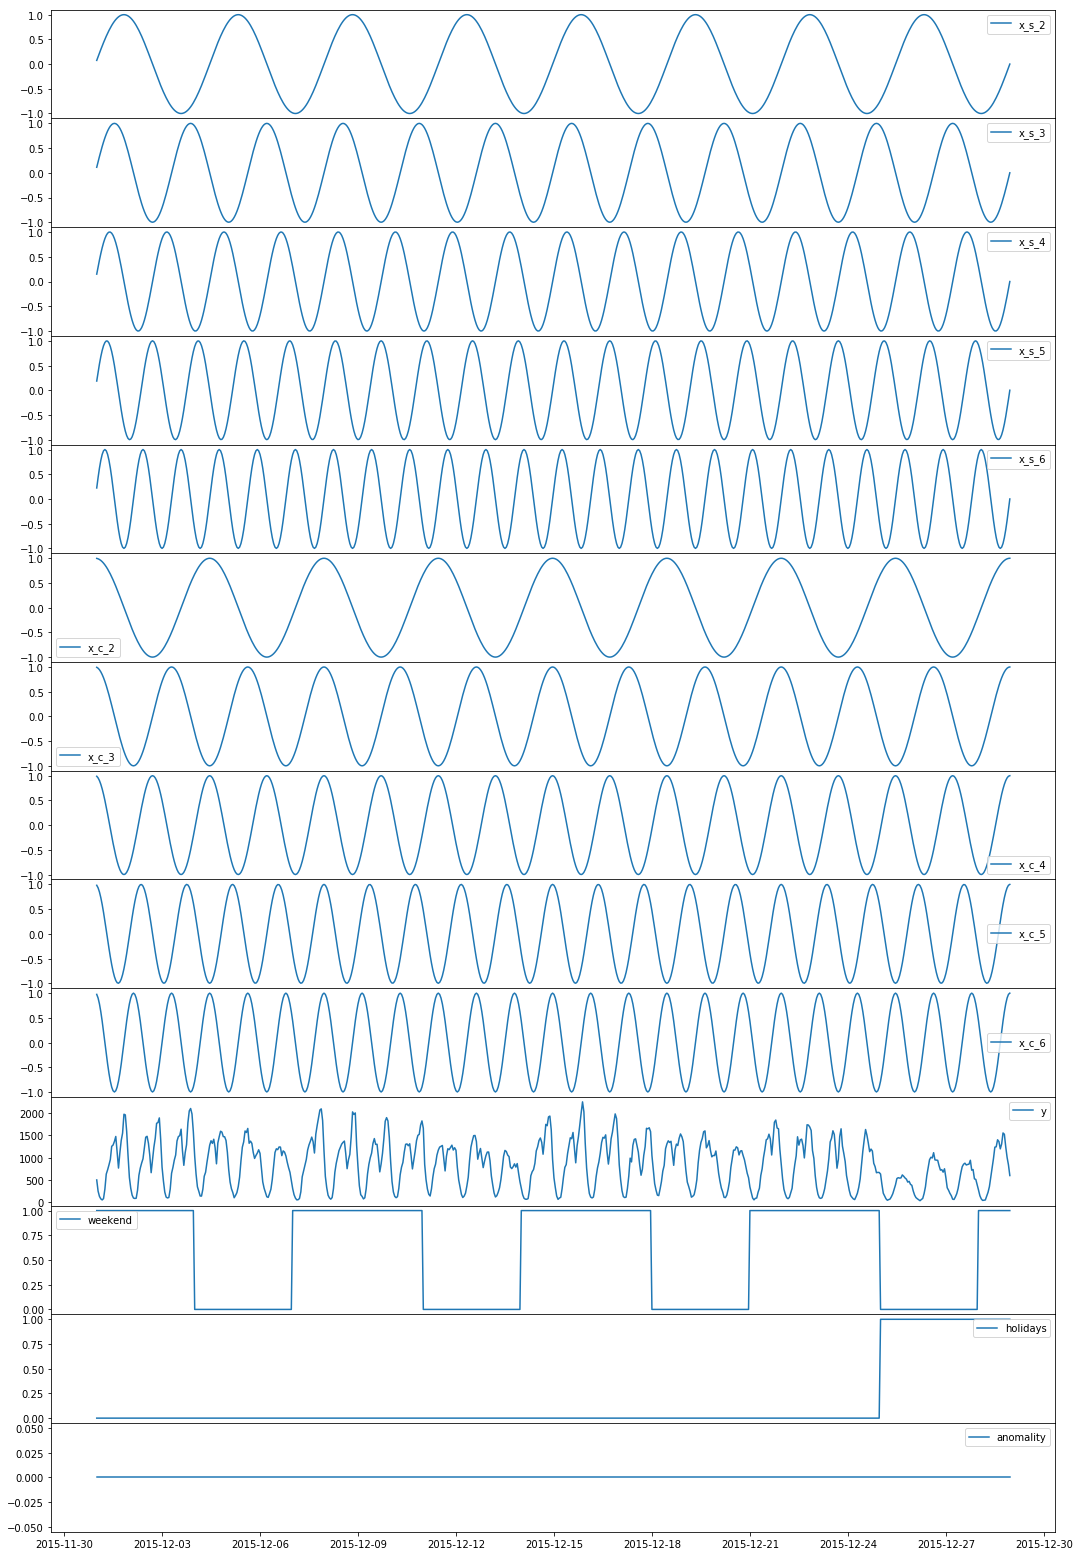

In [13]:
# посмотрим на результат на интервале в 4 недели
fig, axes = plt.subplots(figsize=(18, features.shape[1]*2), nrows = features.shape[1],  sharex=True)

for idx, name in enumerate(features.columns):
    axes[idx].plot(features[name][:168*4], label=name)
    axes[idx].legend()
plt.subplots_adjust(hspace=0)

## 2. Регрессия целевого признака на построенные признаки

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     57.19
Date:                Mon, 22 Jan 2018   Prob (F-statistic):          4.13e-119
Time:                        06:28:33   Log-Likelihood:                -33962.
No. Observations:                4392   AIC:                         6.795e+04
Df Residuals:                    4380   BIC:                         6.802e+04
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           801.8353     12.77

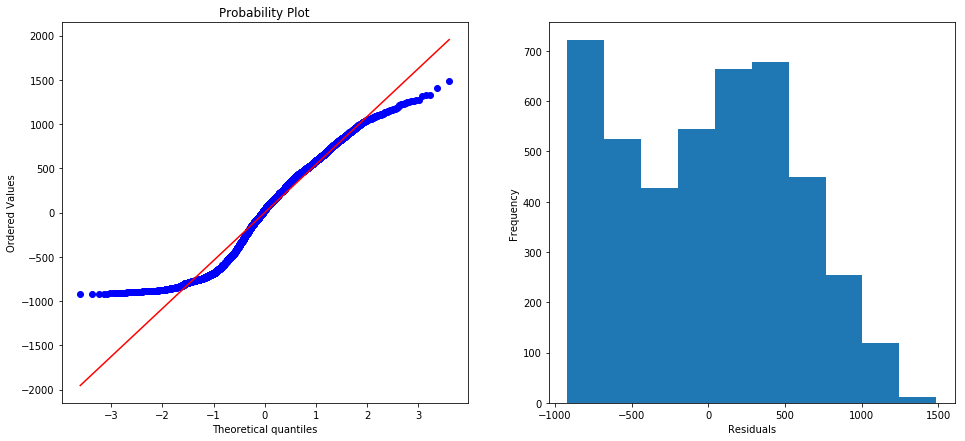

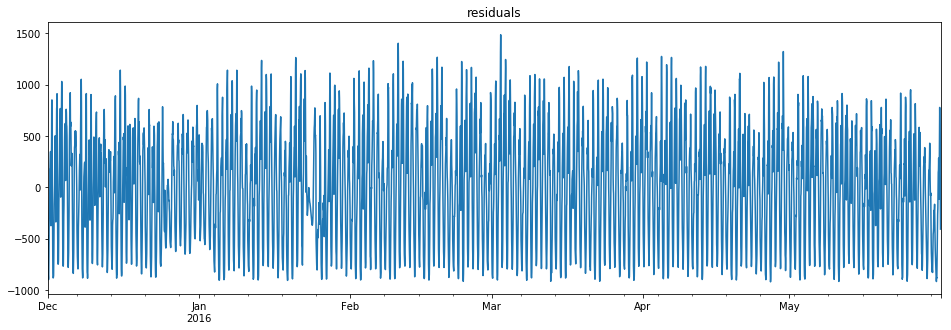

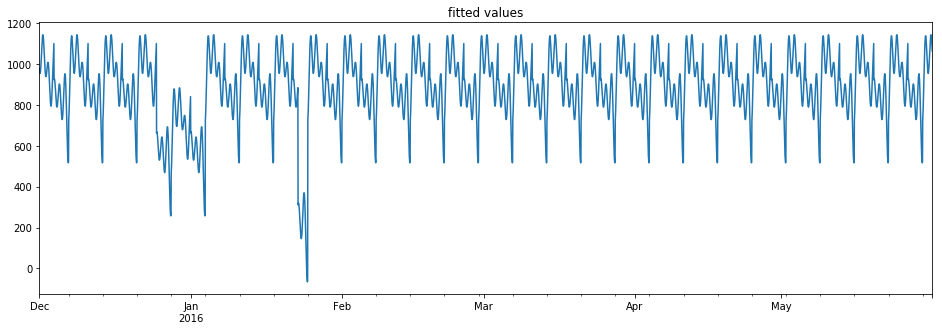

Wall time: 973 ms


In [15]:
%%time
# воспользуемся statmodels
m1 = smf.ols('y~'+'+'.join(features.columns.drop(['y', 'x_c_3', 'x_c_5'])), 
             data=features)
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals')
plt.figure(figsize(16,5))
fitted.resid.plot()
plt.title('residuals')
plt.figure(figsize(16,5))
fitted.fittedvalues.plot()
plt.title('fitted values')
pylab.show()

"""
'x_c_3' и 'x_c_5' алгоритм счел статистически незначимыми
Модель имеет небольшую склонность к занижению прогноза. Причем чаще это максимальное занижение.
Завышение имеет больший разброс, и чаще величина завышения небольшая. В будние дни модель завышает чаще.
Из-за этого визуально в остатках не удалось избавиться от недельной сезонности (
"""
pass

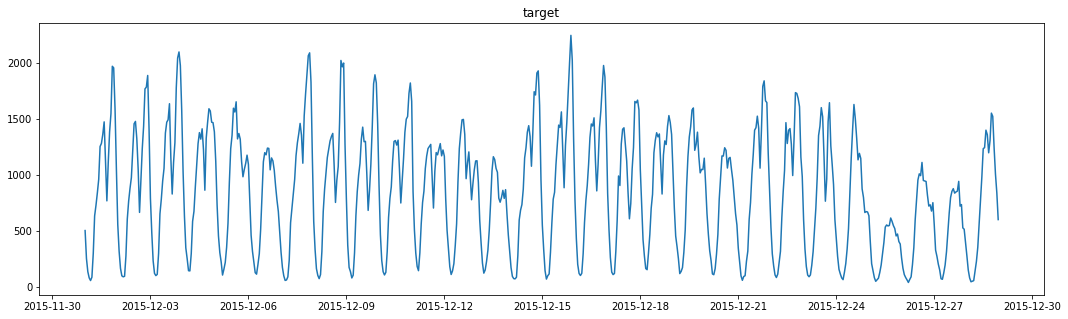

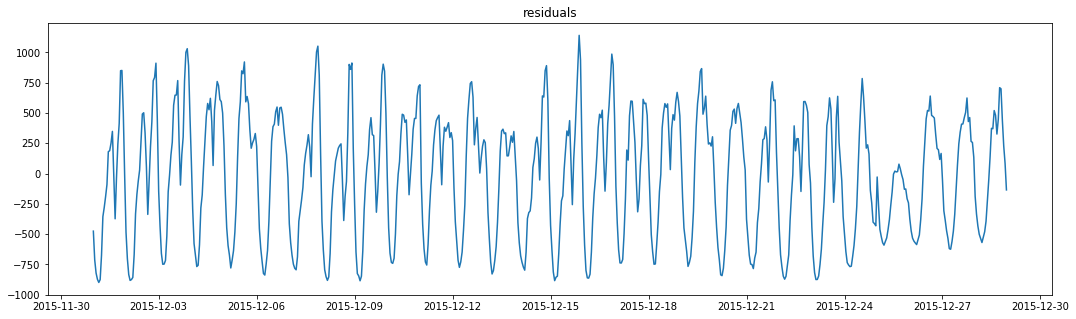

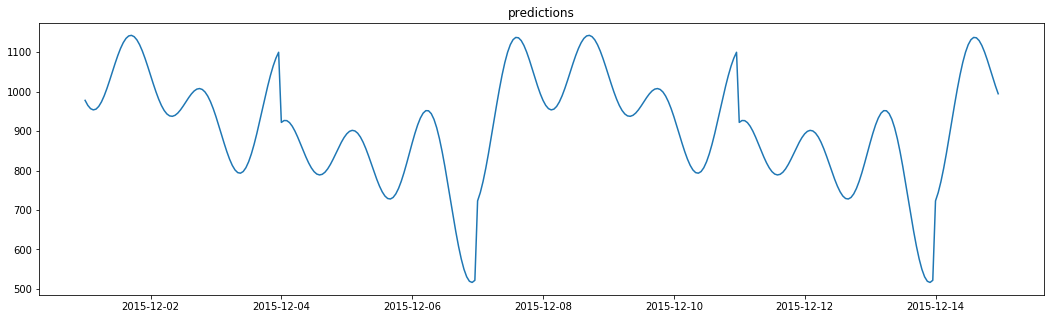

In [16]:
# посмотрим на результаты на двухнедельном интервале
fig, axes = plt.subplots(figsize=(18,5))
plt.plot(features.y[:168*4]);
plt.title('target')
fig, axes = plt.subplots(figsize=(18,5))
plt.plot(fitted.resid[:168*4]);
plt.title('residuals');
fig, axes = plt.subplots(figsize=(18,5))
plt.plot(fitted.fittedvalues[:168*2]);
plt.title('predictions');

"""
Выходные стали чуть менее резко отличаться от будних дней (сравните target и residuals). 
Так что чуть сгладить недельную сезонность все-таки получилось
"""
pass

## 3. Дифференцирование ряда

Критерий Дики-Фуллера: p=0.000000


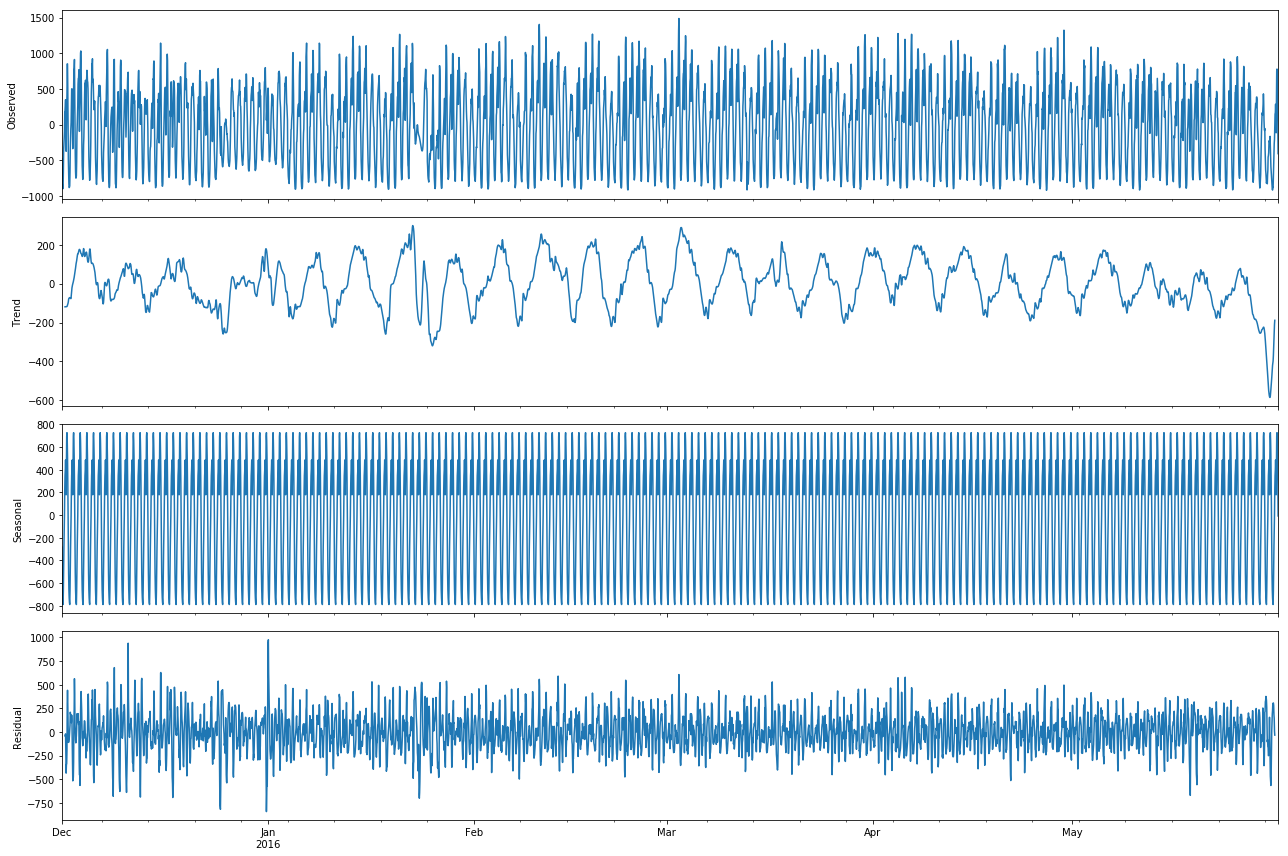

In [17]:
# построим STL-декомпозицию остатков
plt.figure(figsize(18,12))
sm.tsa.seasonal_decompose(fitted.resid).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(fitted.resid)[1]);

"""
Критерий Дики-Фуллера отвергает гипотезу нестационарности ряда. 
Но в трендовой компоненте мы видим явную недельную сезонность
Будем дифференцировать!
"""
pass

In [18]:
residuals = pd.DataFrame(fitted.resid, columns=['resid'])
residuals.head(3)

,resid
2015-12-01 00:00:00,-475.686449
2015-12-01 01:00:00,-712.911635
2015-12-01 02:00:00,-821.722765


Здесь момент творчества. Есть два варианта сезонных лагов 168 и 24. Использовал в разных комбинациях, остановился на этом

Критерий Дики-Фуллера: p=0.000000


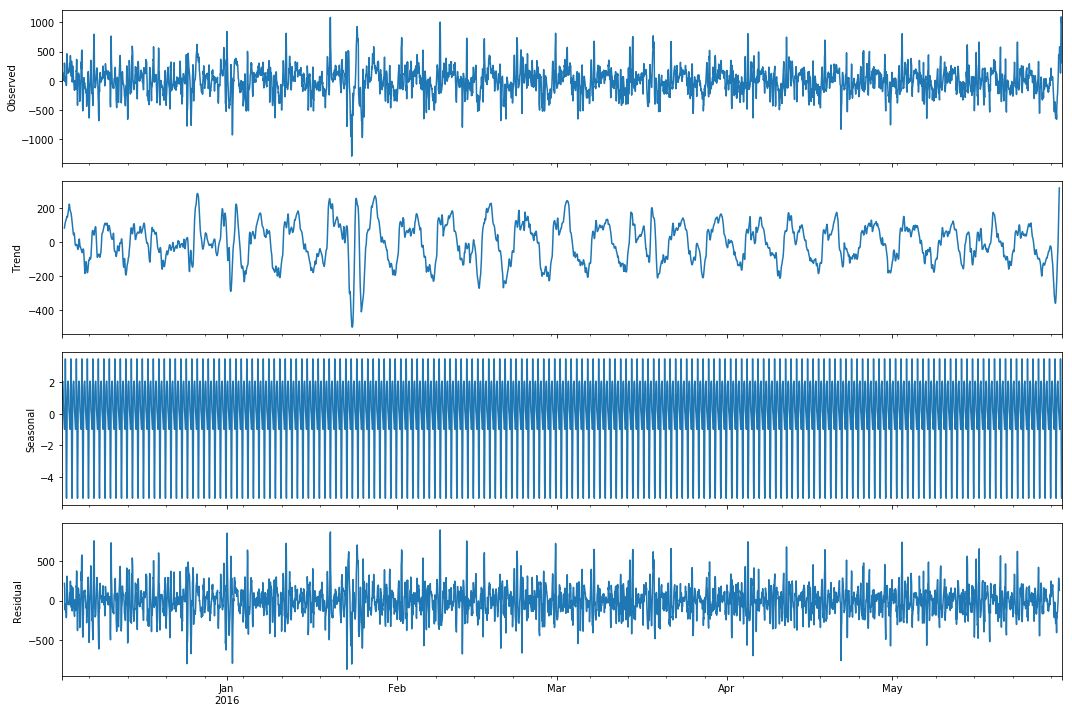

In [19]:
# сначала дифференцируем с сезонным лагом 24 
residuals['resid_diff_s'] = residuals.resid - residuals.resid.shift(24)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(residuals.resid_diff_s.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals.resid_diff_s.dropna())[1]);
"""
В трендовой компоненте осталася явная недельная сезонность 
"""
pass

Критерий Дики-Фуллера: p=0.000000


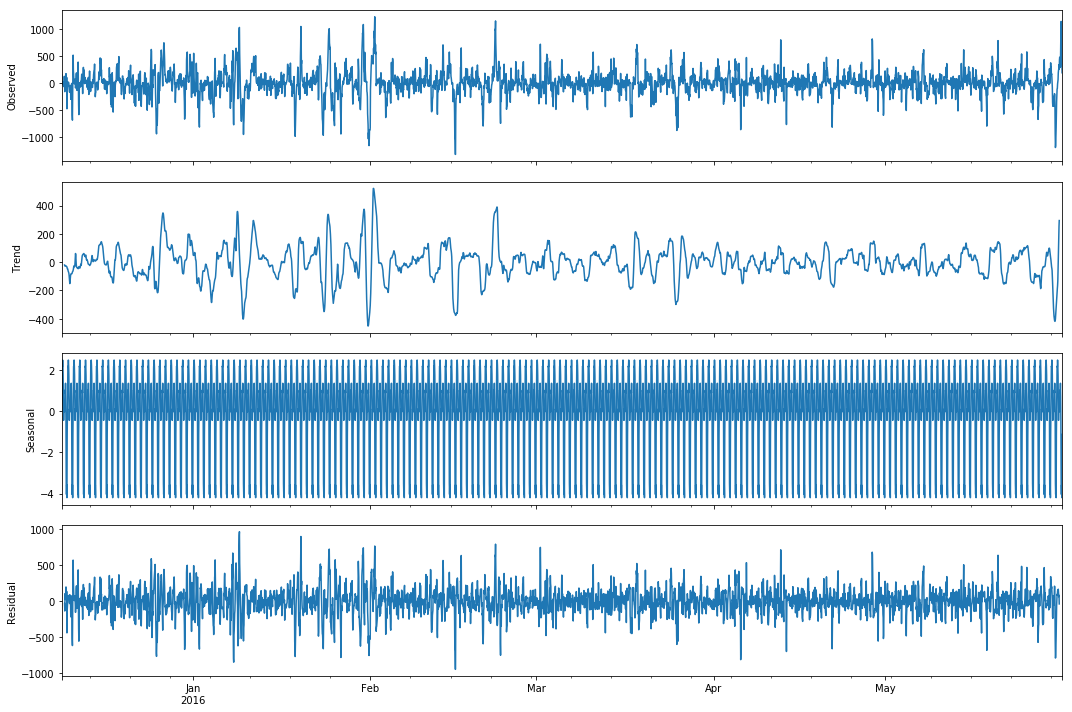

In [20]:
# теперь дифференцируем с сезонным лагом 168
residuals['resid_diff_s_1'] = residuals.resid_diff_s - residuals.resid_diff_s.shift(168)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(residuals.resid_diff_s_1.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals.resid_diff_s_1.dropna())[1])
"""
Трендовой компонента выглядит уже лучше... 
"""
pass

Критерий Дики-Фуллера: p=0.000000


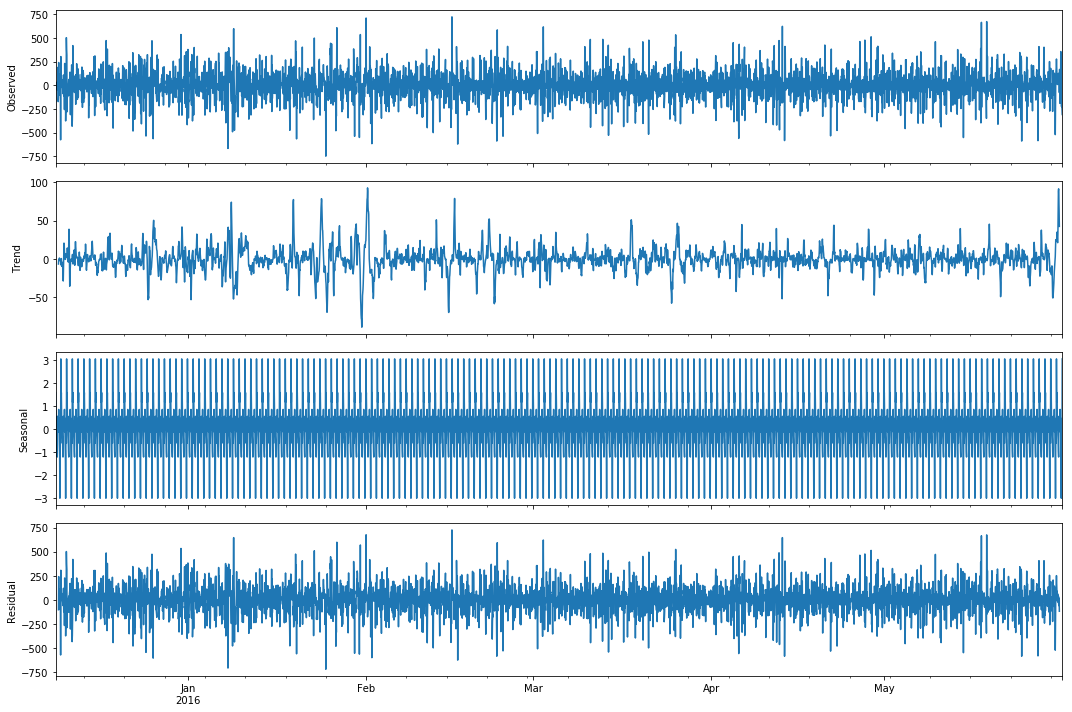

In [21]:
# продифференцируем еще с единичным лагом
residuals['resid_diff_s_2'] = residuals.resid_diff_s_1 - residuals.resid_diff_s_1.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(residuals.resid_diff_s_2.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals.resid_diff_s_2.dropna())[1])
"""
Трендовой компонента все более похожа на "случайную пульсацию". Есть всплески, но надо уже остановиться,
т.к. многократное дифференцирование - не есть хорошо
"""
pass

## 4. Подбор гиперпараметров и построение модели

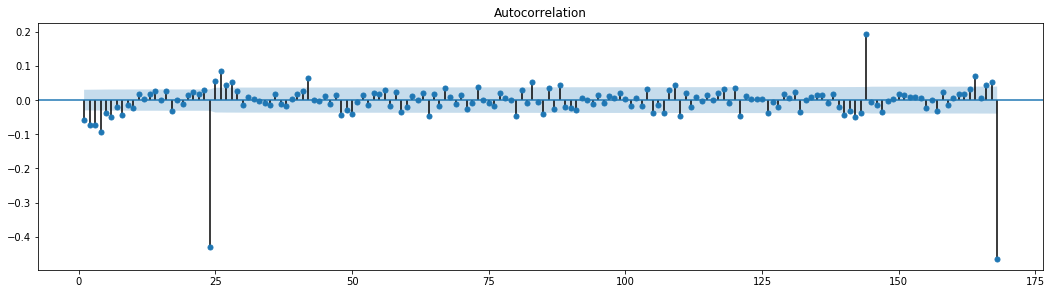

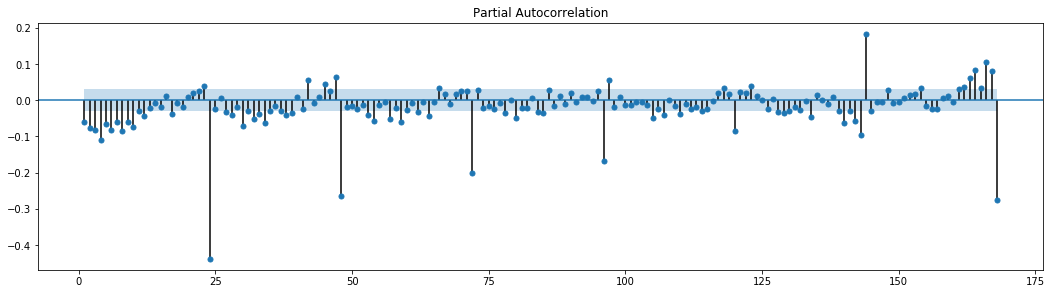

In [22]:
# подбираем параметры модели
plt.figure(figsize(18,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residuals.resid_diff_s_2.dropna().values.squeeze(), lags=168, ax=ax, zero=False)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residuals.resid_diff_s_2.dropna().values.squeeze(), lags=168, ax=ax, zero=False)
pylab.show()

"""
Дифференцирование остатков, которым страдали выше, было ради выбора параметров. 
Но в выборе параметров есть еще одно существенное ограничение - терпение в ожидании окончания расчета
Тот факт, что SARIMAX бывает падает через часок расчетов по исключению singular matrix (не часто), 
не добавляет желания увеличивать количество параметров. Поэтому на коррелограммы я, конечно, посмотрел,
но гиперпараметры выбрал по своему усмотрению, чуть ниже рекомендуемых
"""
pass

**Начальные приближения установим следующие:**
- $q = 5$ 
- $Q = 1$
- $p = 8$ 
- $P = 1$

In [23]:
ps = range(0, 9)
d = 1 # одно простое
qs = range(0, 6) 
Ps = range(0, 1)
D = 2 # два сезонных
Qs = range(0, 1)

In [24]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [27]:
%%time
# заготовка из C5W1
results = []
best_aic = float("inf")

# c tqdm не так утомительно ждать; если не установлен, переставьте комментарий
#for param in parameters_list:
for param in tqdm_notebook(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(cell_data, 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog=features[features.columns.drop(
                                            ['y', 'x_c_3', 'x_c_5'])].astype({'weekend':'int8', 
                                                                              'holidays':'int8',
                                                                              'anomality':'int8'})
                                       ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

A Jupyter Widget

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 4, 0, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 5, 0, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 5, 0, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 5, 0, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 5, 0, 0)
wrong parameters: (7, 3, 0, 0)
wrong parameters: (7, 4, 0, 0)
wrong parameters: (7, 5, 0, 0)
wrong parameters: (8, 3, 0, 0)

Wall time: 1h 28min 53s


In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
29  (8, 5, 0, 0)  57971.533923
28  (8, 4, 0, 0)  58112.323062
17  (5, 1, 0, 0)  58275.512139
20  (6, 1, 0, 0)  58275.731454
7   (1, 4, 0, 0)  58277.922725


## 5. Сопоставление графика исходного ряда и предсказания выбранной модели

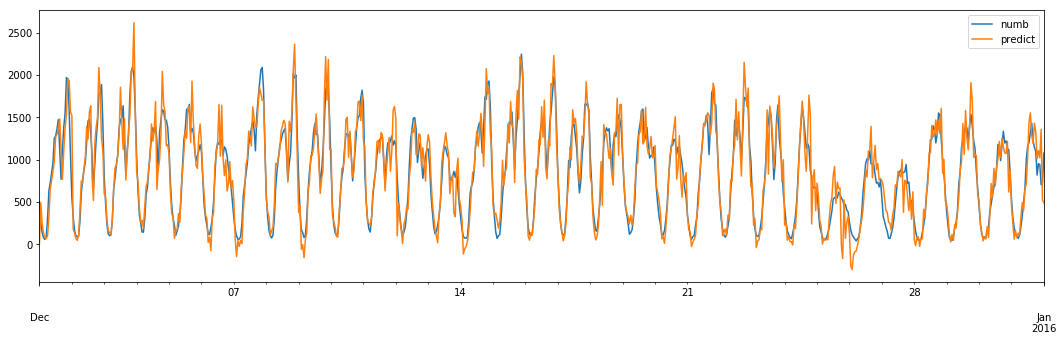

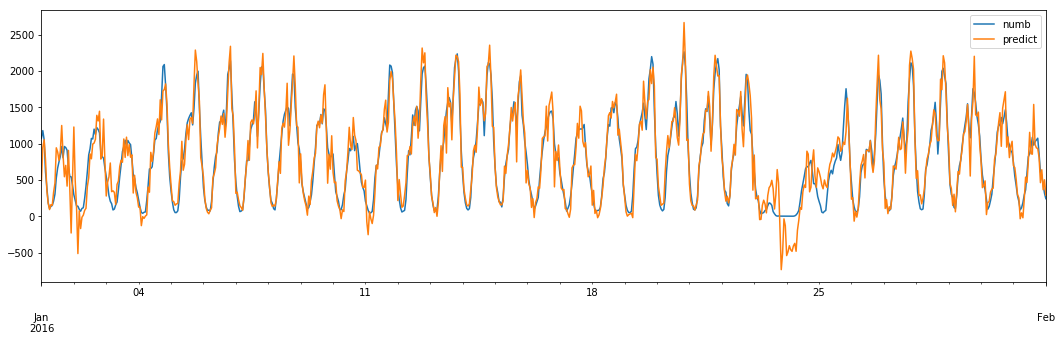

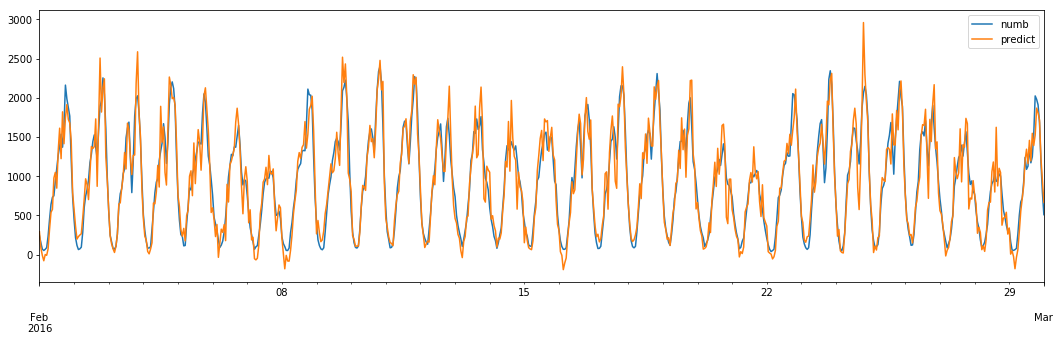

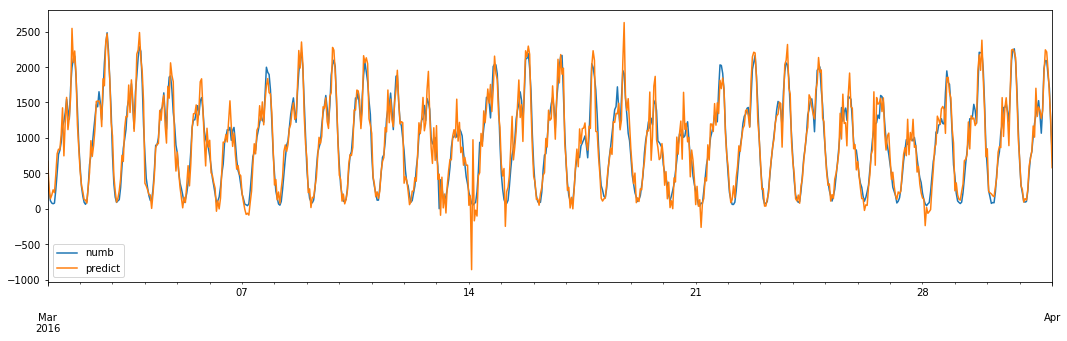

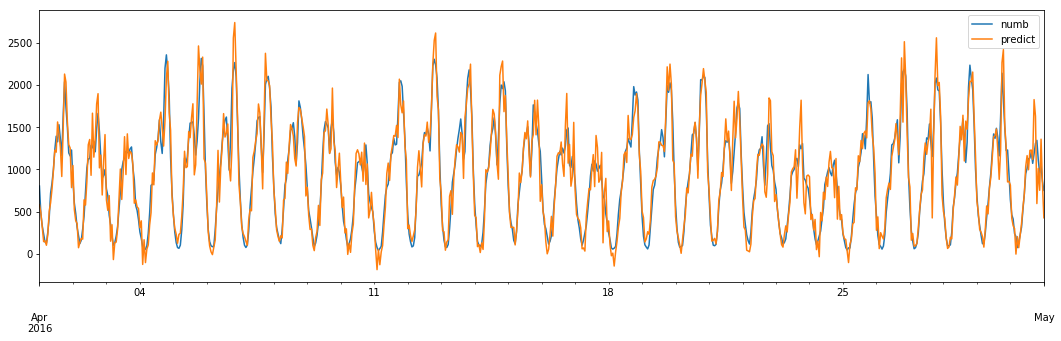

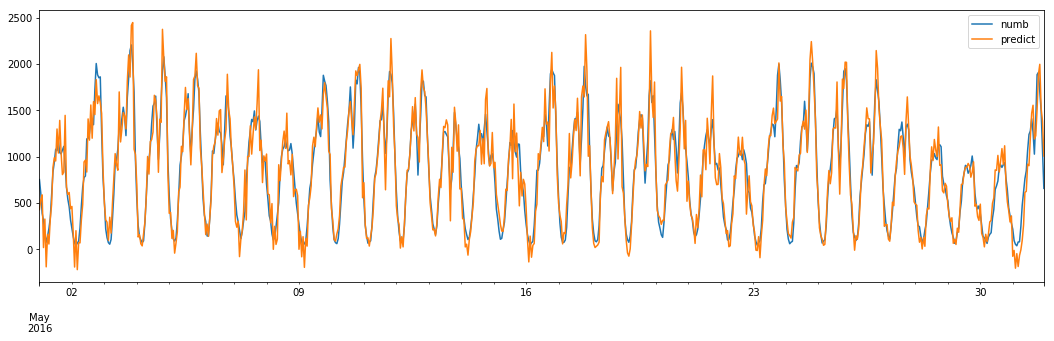

In [29]:
# разобьем график помесячно, так лучше видно
st = datetime.datetime.strptime("2015-12-01", "%Y-%m-%d")
for i in range(1,7):
    plt.figure(figsize(18,5))
    cell_data[st:st+relativedelta(months=1)].plot(label='data', legend=True)
    best_model.fittedvalues[st:st+relativedelta(months=1)].plot(label='predict', legend=True)
    st = st+relativedelta(months=1);

## 6. Анализ качества модели

In [30]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               numb   No. Observations:                 4392
Model:             SARIMAX(8, 1, 5)x(0, 2, 0, 24)   Log Likelihood              -28959.767
Date:                            Mon, 22 Jan 2018   AIC                          57971.534
Time:                                    08:02:51   BIC                          58137.610
Sample:                                12-01-2015   HQIC                         58030.125
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_s_2         37.7439     17.289      2.183      0.029       3.858      71.630
x_s_3         16.7993      7.257   

Критерий Стьюдента: p=0.928107
Критерий Дики-Фуллера: p=0.000000


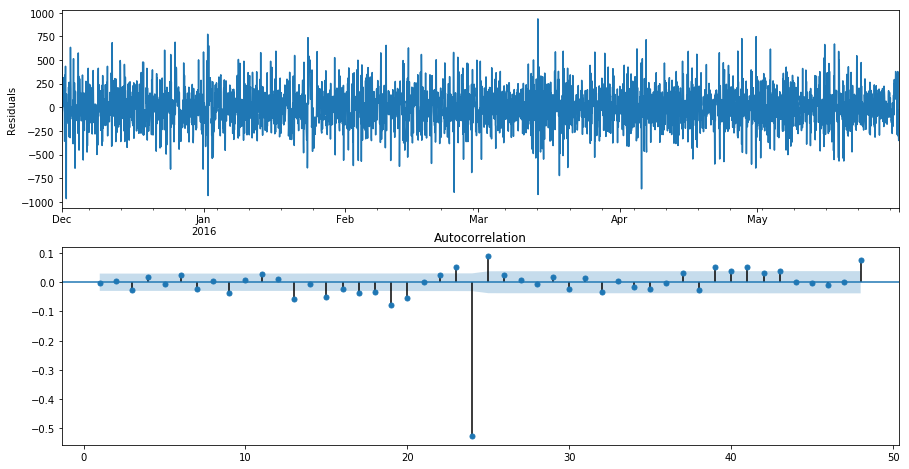

In [31]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax, zero=False)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[168+24*2:])[1])

In [42]:
print('среднечасовое значение поездок из выбранной зоны - {0:.2f}, корень из среднеквадратичной ошибки прогноза - {1:.2f}' 
      .format(cell_data.mean()[0], sqrt(metrics.mean_squared_error(cell_data, best_model.fittedvalues))))

среднечасовое значение поездок из выбранной зоны - 889.31, корень из среднеквадратичной ошибки прогноза - 191.01


**Выводы:**

**остатки не смещены** - подверждается критерием Стьюдента (не отвергнута гипотеза о равенстве среднего нулю);

**остатки стационарны** - подтверждается критерием Дики-Фуллера (отвергнута гипотеза о нестационарности остатков) и визуально

**остатки автокоррелированы** - подтверждается критерием Льюнга-Бокса (отвергается гипотеза о том, что данные являются "белым шумом") и коррелограммой - имеются статистически значимые отклонения от нуля). Особенно смущает сильно автокоррелированный сезонный лаг. Что-то есть в данных, что не учитывает наша модель.

Дисперсия остатков великовата. Соотношение среднечасового количества поездок, и среднеквадратичной ошибки прогноза указывает на то, что процентов на 20% мы в среднем ошибаемся. Многовато... Но, с другой стороны, мы не мажем совсем мимо! То есть прогноз не выглядит абсолютным бредом :)

Попытки улучшить прогноз на участках праздников и прочих аномалий (добавление признаков), существенных улучшений не дали.

Возможно это все следствие волюнтаризма в выборе гиперпараметров, но времени для экспериментов оказалось недостаточно